In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import gzip
from sklearn.utils import resample

from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1.Load Data

In [0]:
with gzip.open('/content/drive/My Drive/0. Uconn/Capstone/alldata_withlinks1.csv.gz') as f:
    df0 = pd.read_csv(f)
df0.drop(columns='Unnamed: 0',inplace=True)

In [0]:
df3 = pd.read_csv('/content/drive/My Drive/0. Uconn/Capstone/Top_Seller_List.2020_02_10.sellers.csv')
df3.drop(columns=' ',inplace=True)

In [0]:
df4 = pd.read_csv('/content/drive/My Drive/0. Uconn/Capstone/$seller_source_202002141505 (1).csv')

# 2.Data Preparaion

## Data Preparation for df0(aggregated listing counts by ID and renamed it as df1)

In [0]:
# changed the data type of "Listing count" into numeric data type 
df0['Listing_count'] = df0['Listing_count'].str.replace(',','')
df0['Listing_count'] = df0['Listing_count'].astype(int)

In [0]:
# Aggregated the listing count by ID and rename as df1
df1 = df0.groupby('ID')['Listing_count'].sum().reset_index()

## Data Preparation for df3 (Top Sellers)

In [0]:
# Seperate the "Selling primarily" data into two new columns, the categories of selling primarily and the percentage of them
df3['SP'] = df3['Selling primarily'].str.findall('(.*) \(')
df3['SP_%'] =df3['Selling primarily'].str.findall('\((.*) %\)')
df3['SP'] = [','.join(map(str, l)) for l in df3['SP']]
df3['SP_%'] = [','.join(map(str, l)) for l in df3['SP_%']]

## Data Preparation for df4 (resource) 

In [0]:
# There're 24 missing values in sources, which should be removed especially in the target variable
df4 = df4.dropna()

In [0]:
# Lowercase of the sources
df4.seller_source = df4.seller_source.str.lower()

In [0]:
# Create a dictionary to unify the similary source name 
dic ={'ingram micro':'memphis',
      'ingram micro tlp (memphis)':'memphis',
      'amazon.com':'amazon',
      'amazon.com.indc llc':'amazon',
      'amazon us':'amazon',
      'walmart / sams club/target/costco/walmart / sams club/costco/walmart / sams club/target':'walmart/sams club/target/costco/walmart',
      'target/costco/walmart / sams club/costco':'target/costco/walmart/sams club',
      'lowes.(canada)':'lowes',
      'walmart / sams club/costco/target/costco':'walmart/sams club/costco/target',
      'home depot canada':'home depot',
      'home depot rdc #5520 70073789':'home depot',
      'home depot rdc #5642 65236701':'home depot',
      ' dock 4 900 guelph on n1h 1b4':'synnex',
      '107 woodlawn road west':'synnex',
      '205 courtneypark drive west 900 mississauga on l5w 0a5':'dollar tree',
      '450 derwent place 900 delta bc v3m 5y9':'amazon'}

In [0]:
# Replace source names based on the above dictionary
df4['seller_source'] = df4['seller_source'].replace(dic)

In [0]:
# Unify the format in the source variable
df4['seller_source'] = df4.seller_source.str.replace(' /','/')
df4['seller_source'] = df4.seller_source.str.replace('/ ','/')
df4['seller_source'] = df4.seller_source.str.replace(' / ','/')

In [0]:
# Split the source variable by "/" into list data format
df4['nr'] = df4.seller_source.str.split('/')

In [0]:
# Create dummy variables and called it "nrdum"
nrdum = df4['nr'].str.join(sep=',').str.get_dummies(sep=',')

In [0]:
# Remove the original resource variables and concatenate the dummy variables based on index
df4 = pd.concat([df4, nrdum], axis=1)
df4.drop(columns=['seller_source', 'nr'], inplace=True)

In [0]:
# To remove the duplicates in seller_id and seller_name in rows, we aggregated the numbers of sources by ID and seller name
df4_1 = df4.groupby(['seller_id','seller_name']).sum()

In [0]:
# Reset index
df4_1.reset_index(inplace=True)

In [0]:
# Unify the same srouce, synnex, has different names as addresses
df4_1.rename(columns={' dock 4 900 guelph on n1h 1b4':'synnex0','107 woodlawn road west':'synnex1'},inplace=True)
df4_1['synnex'] = df4_1['synnex0'] + df4_1['synnex1']
df4_1.drop(columns=['synnex0','synnex1'],inplace=True)

In [0]:
# Keep the number into binary to show that the sellers were resoucing form certain source or not
df4_1.replace(2,1,inplace=True)

# 3.Basic Check

In [0]:
print(df1.ID.nunique())

114124


In [0]:
print(df3.Name.nunique())
print(df3['Seller Id'].nunique())

99898
100000


In [0]:
print(df4_1.seller_name.nunique())
print(df4_1.seller_id.nunique())

2469
2562


## Multiple ID for the same seller

In [0]:
b = df0.groupby('Seller')['ID'].nunique()
b = b.reset_index()
b[b.ID>1]

,Seller,ID
27407,E-Z ink Storefront,2
29155,Electronics Discounted Storefront,2


In [0]:
a = df4.groupby('seller_name')['seller_id'].nunique()

In [0]:
a=a.reset_index()

In [0]:
a[a.seller_id>2]

,seller_name,seller_id
262,BAZINGA TRADING,3
458,CHAMPION VALUES,3
631,DIRTCHEAPSELLERMS,3
673,E ZEE ELECTRONICS,3
949,GOODSRETAILSTORE,4
952,GOURMET KITCHEN,3
1133,INFINITYANDBEYOND,3
1143,INTERBIZ. US,3
1580,OCEANS WHOLESALE,3
2116,TECHNO CITY INC,3


# 4.Merge Comparison

In [0]:
# R1: merge df0 and df3 based on ID with inner joinned.
# Present the number of nuique seller ID
r1 = pd.merge(df0, df3, how='inner', left_on='ID', right_on='Seller Id')
r1.ID.nunique()

69262

In [0]:
# R2: merge df0 and df4_1 based on ID with inner joinned
# Present the number of nuique seller ID
r2 = pd.merge(df0, df4_1, how='inner', left_on='ID', right_on='seller_id')
r2.ID.nunique()

1567

In [0]:
# R3: merge df3 and df4 fist, then merge to df1 based on ID with inner joinned
# Present the number of nuique seller ID

a =pd.merge(df3, df4, how='inner', left_on='Seller Id', right_on='seller_id')
r3 = pd.merge(df1, a, how='inner', left_on='ID', right_on='Seller Id')
r3.ID.nunique()

1324

In [0]:
# R4: merge df1 and df4_1 based on ID with inner joinned
# Present the number of nuique seller ID

r4 = pd.merge(df1, df4_1, how='inner', left_on='ID', right_on='seller_id')
r4.ID.nunique()

1567

In [0]:
# R5: merge df3 and df4_1 fist, then merge to df1 based on ID with inner joinned
# Present the number of nuique seller ID

a_1 =pd.merge(df3, df4_1, how='inner', left_on='Seller Id', right_on='seller_id')
r5 = pd.merge(df1, a_1, how='inner', left_on='ID', right_on='seller_id')
r5.ID.nunique()

1324

In [0]:
# Show the number of rows and columns in each merged dataset
# After discussion, the team decided to go with r5 because it has more informations in features and without duplicated seller ID

print("r1:", r1.shape)
print("r2:", r2.shape)
print("r3:", r3.shape)
print("r4:", r4.shape)
print("r5:", r5.shape)

r1: (11683549, 14)
r2: (698700, 34)
r3: (1510, 43)
r4: (1567, 32)
r5: (1324, 42)


# 5.Pre-processing r5(3+4, then combined with1)

## Remove source columns that no sellers were sourcing from

In [0]:
# Drop unnecessary columns

r5 = r5.reindex(columns=(['Name'] + list([a for a in r5.columns if a !='Name']) ))
r5.drop(columns=['seller_name','Seller Id','seller_id'],inplace=True)

In [0]:
# Check the sources that no sellers were resourcing from, and put them into app variables
# Print out the sources that at least one seller were sourcing from.

app =[]
for i in range(11,38):
  if r5.iloc[:,i].unique().any() ==1:
    print(r5.columns[i])
  else:
    app.append(i)

adt llc
amazon
best buy
big 5 electronics
bj's wholesale
costco
dollar tree
home depot
lowes
memphis
office depot
overstock.com
rona inc
sams club
sears
target
tri-ed distribution
walmart
your other warehouse


In [0]:
# drop the columns that no seller were sourcing from
r5.drop(r5.columns[app], axis=1, inplace=True)

In [0]:
# There are 8 sources that were not sourcing by sellers
print (r5.shape)

(1324, 31)


In [0]:
# Show the number times of

r5.iloc[:,11:].sum()

adt llc                    1
amazon                     3
best buy                   6
big 5 electronics          1
bj's wholesale             1
costco                  1044
dollar tree                1
home depot                10
lowes                      9
memphis                    7
office depot               1
overstock.com              1
rona inc                   1
sams club                174
sears                    125
target                    56
tri-ed distribution        2
walmart                  174
your other warehouse       2
synnex                     1
dtype: int64

## Percentage of different number of sources

In [0]:
# Calculate how many resources that sellers were resourcing from
r5['num_reso'] = r5.iloc[:,11:].sum(axis=1)

In [0]:
round(r5.num_reso.value_counts().apply(lambda x:x/1324*100),2)

1    84.89
2     9.29
3     4.68
4     0.98
7     0.08
5     0.08
Name: num_reso, dtype: float64

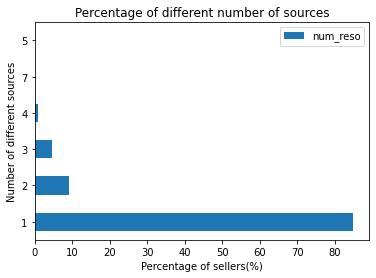

In [0]:
# Show the results
ax =r5.num_reso.value_counts().apply(lambda x:x/1324*100).plot.barh()
ax.set_xlabel('Percentage of sellers(%)')
ax.set_ylabel('Number of different sources')
ax.set_title('Percentage of different number of sources')
ax.legend()

## Group the sourses that were sourced by at least 2 sellers as "Walmart"
We found that within this group, 88% are Walmart and Sam's Club

In [0]:
# Change multi-resouces into 0 value in num_reso variable.
# 1: Sellers were sourcing one source 
# 0: Sellers were sourcing more than one source 

r5['num_reso'].replace({2:0,3:0,4:0,5:0,7:0},inplace=True)

In [0]:
# The number of unique sellers in each group 

r5.num_reso.value_counts()

1    1124
0     200
Name: num_reso, dtype: int64

In [0]:
# Within the multiple-sources group, most of sellers were sourcing from Walmart and Sam's Club 

r5.iloc[:,11:][r5.num_reso ==0].sum()

adt llc                   1
amazon                    2
best buy                  3
big 5 electronics         0
bj's wholesale            1
costco                   79
dollar tree               1
home depot                9
lowes                     6
memphis                   3
office depot              0
overstock.com             1
rona inc                  1
sams club               174
sears                    13
target                   24
tri-ed distribution       1
walmart                 174
your other warehouse      2
synnex                    1
num_reso                  0
dtype: int64

In [0]:
# Within the one-source group, there're few sources were not resouring from the sellers

r5.iloc[:,11:-1][r5.num_reso ==1].sum()

adt llc                   0
amazon                    1
best buy                  3
big 5 electronics         1
bj's wholesale            0
costco                  965
dollar tree               0
home depot                1
lowes                     3
memphis                   4
office depot              1
overstock.com             0
rona inc                  0
sams club                 0
sears                   112
target                   32
tri-ed distribution       1
walmart                   0
your other warehouse      0
synnex                    0
dtype: int64

In [0]:
# Remove the redundant columns

rm_lst = r5.iloc[:,11:-1][r5.num_reso ==1].sum().reset_index()[r5.iloc[:,11:-1][r5.num_reso ==1].sum().reset_index()[0]==0]['index'].values
r5.drop(columns=rm_lst, inplace=True)

In [0]:
# Create a new cloumn contains the sellers were sourcing from
# Encode the multiple-source into "Walmart" (as value 1) 

r5['target_reso']= r5.iloc[:,11:-1].idxmax(axis=1)
r5.loc[r5.num_reso==0, ['target_reso']] = 0

## Group the sources that the sellers were sourced by less than 4 sellers as "Min-seller"

In [0]:
# The number of sellers in each source
# We found that there are 8 sources were sourced by less than 4 sellers

r5.target_reso.value_counts()

costco                 965
0                      200
sears                  112
target                  32
memphis                  4
best buy                 3
lowes                    3
home depot               1
office depot             1
tri-ed distribution      1
big 5 electronics        1
amazon                   1
Name: target_reso, dtype: int64

In [0]:
# Encoded the sources that were sourced by less than 4 sellers into "Min-seller" group (as value 1)

min_lst = r5.target_reso.value_counts().reset_index()[r5.target_reso.value_counts().reset_index()['target_reso']<5]['index'].to_list()
r5.loc[r5.target_reso.isin(min_lst), ['target_reso']] = 1

In [0]:
# The number of sellers in each group with combined target sources

r5.target_reso.value_counts(sort=False)

0         200
1          15
sears     112
costco    965
target     32
Name: target_reso, dtype: int64

In [0]:
# Encode the groups into numeric
# 0: Walmart with multiple sources
# 1: Min-seller
# 2: Costco
# 3: Sears
# 4: Target

r5.target_reso = r5.target_reso.astype('category')
r5.target_reso = r5.target_reso.cat.codes
r5.target_reso.value_counts(sort=False)

0    200
1     15
2    965
3    112
4     32
Name: target_reso, dtype: int64

In [0]:
# Remove the dummy variables for sources 

r5.drop(columns=r5.columns[range(r5.columns.get_loc('amazon'),r5.columns.get_loc('num_reso')+1)], inplace = True)

# 6.Oversampling
We will face imbalance classification problem if we didn't perform any resample methods.

In [0]:
# Group all the sources except Costco group into 0 value in order to perform oversampling

r5['target_balance'] = [1 if n==2 else 0 for n in r5.target_reso]
r5.target_balance.value_counts()

1    965
0    359
Name: target_balance, dtype: int64

In [0]:
# Perform oversampling and save the result into variable called "df_upsampled"

df_majority = r5[r5.target_balance==1]
df_minority = r5[r5.target_balance==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=965,    # to match majority class
                                 random_state=123)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [0]:
# The numbers of sellers in each group after oversampling 

df_upsampled.target_reso.value_counts(sort=False)

0    562
1     34
2    965
3    284
4     85
Name: target_reso, dtype: int64

In [0]:
# We made the number of the minority group equals to the Costco group

df_upsampled.target_balance.value_counts(sort=False)

0    965
1    965
Name: target_balance, dtype: int64

In [0]:
# Remove target_balance variable

df_upsampled.drop(columns='target_balance',inplace=True)

# 7.Extract the most frequent Brands within the combined dataset

In [0]:
# Found the seller ID of combined dataset in the df0 

id = r5.ID.unique()
a = df0[df0.ID.isin(id)].copy()
a['Brand'] = a.Brand.astype(str)
print('The number of unique brand names without removing space and special character: ', a.Brand.nunique())

# Remove space in Brand names
a['Brand'] = a['Brand'].str.replace(" ","")

# Remove special characters in Brand names
a['Brand'] = a['Brand'].map(lambda x: re.sub(r'\W+', '', x))
a['Brand'] = a['Brand'].map(lambda x: re.sub(r"\b\d+\b", '', x))
a['Brand'] = a['Brand'].str.lower()

The number of unique brand names without removing space and special character:  195882


In [0]:
# Calculated how many sellers sold the brands
# There are 172,132 brands, and the top two are "unknown" and "generic"

b = a.groupby('Brand')['ID'].nunique().reset_index()
print('The number of unique brand names with removing space and special character: ', b.Brand.nunique())

b.sort_values('ID',ascending=False).head(10)

The number of unique brand names with removing space and special character:  172132


,Brand,ID
159746,unknown,701
64466,generic,456
586,3m,307
47525,disney,294
41277,crayola,222
16483,bic,213
87312,kirklandsignature,213
132855,rubbermaid,208
8893,armhammer,201
119351,philips,195


In [0]:
# Drop the "unknown", "generic", and blank which only contatins special characters

b = b.drop(labels=[159746,64466,0],axis=0).sort_values('ID',ascending=0)

In [0]:
# Keep the first 100 brands with frequency sold by sellers 
# Get the top 10 brands

b.rename(columns={'ID':'Freq'}, inplace=True)
b.sort_values('Freq', ascending=0).head(10)

,Brand,Freq
586,3m,307
47525,disney,294
41277,crayola,222
87312,kirklandsignature,213
16483,bic,213
132855,rubbermaid,208
8893,armhammer,201
119351,philips,195
144564,starbucks,194
91380,lego,191


In [0]:
# Get the top 100 brands' name and make the other brands as "others"

brand_list = b.sort_values('Freq', ascending=0).head(100)['Brand'].to_list()
a.loc[~a.Brand.isin(brand_list),'Brand'] = 'others'

In [0]:
# Aggregate the brand name based on ID

df_brands = a.groupby('ID').agg(brands=('Brand','/'.join)).reset_index()
df_brands['brands'] = df_brands.brands.str.split('/').apply(lambda x:set(x))

# Show the table
df_brands.head()

,ID,brands
0,A03522952ZBEMO4MWAXFB,"{command, bic, postit, others, papermate, cray..."
1,A0802152341IQR795Y3SJ,{others}
2,A100R0XTJ2SOGL,"{neutrogena, hotwheels, cuisinart, adidas, dis..."
3,A101C9EQ4N9T2Z,"{ge, hotwheels, olay, crayola, dial, procterga..."
4,A101WUF3E63OK5,{others}


## Transform the top 100 brands into dummy variables

In [0]:
# Make dummy variables and concatenate with "df_brands"

nbdum = df_brands['brands'].str.join(sep=',').str.get_dummies(sep=',')
df_brands = pd.concat([df_brands['ID'], nbdum],axis=1)

In [0]:
# Merge dummy variables of top 100 brands into r5 dataset

r5 = r5.merge(df_brands,on='ID')
df_upsampled = df_upsampled.merge(df_brands,on='ID')

# 8.Pre-processing the dataset
- Binning the Listing_count/ Rating % /Total Review Count
- Create dummy variables for categorical variables
- Remove categorial features and unnecessary features


## Data Binning

In [0]:
# Remove the brand names for visualization dataset

r5.drop(columns=r5.columns[range(r5.columns.get_loc('target_balance'),r5.columns.get_loc('ziploc')+1)], inplace= True)

In [0]:
# Data Binning for Verified Listing with the threshold by discussion

r5.loc[(r5['Verified Listings']>=10000),'VL'] = 'Most Verified'
r5.loc[((r5['Verified Listings']>=1000)&(r5['Verified Listings']<10000)),'VL'] = 'Upper Verified'
r5.loc[((r5['Verified Listings']>100)&(r5['Verified Listings']<1000)),'VL'] = 'Lower Verified'
r5.loc[(r5['Verified Listings']<=100),'VL'] = 'Least Verified'

r5.VL.value_counts()/r5.shape[0]*100

Lower Verified    39.123867
Least Verified    25.302115
Upper Verified    24.471299
Most Verified     11.102719
Name: VL, dtype: float64

In [0]:
# Data Binning for Rating % with the threshold by discussion

r5.loc[(r5['Rating %']>=95),'Rating%'] = 'High Rating'
r5.loc[((r5['Rating %']>85)&(r5['Rating %']<95)),'Rating%'] = 'Medium Rating'
r5.loc[(r5['Rating %']<=85),'Rating%'] = 'Low Rating'

r5['Rating%'].value_counts()/r5.shape[0]*100

High Rating      59.441088
Medium Rating    29.380665
Low Rating       11.178248
Name: Rating%, dtype: float64

In [0]:
# Data Binning for Total Review Count with the threshold by discussion

r5.loc[(r5['Review Count: Total']>=50000),'RT'] = 'Most Reviewed'
r5.loc[((r5['Review Count: Total']>=10000)&(r5['Review Count: Total']<50000)),'RT'] = 'Upper Reviewed'
r5.loc[((r5['Review Count: Total']>1000)&(r5['Review Count: Total']<10000)),'RT'] = 'Lower Reviewed'
r5.loc[(r5['Review Count: Total']<=1000),'RT'] = 'Least Reviewed'

r5.RT.value_counts()/r5.shape[0]*100

Lower Reviewed    52.190332
Least Reviewed    20.619335
Upper Reviewed    18.655589
Most Reviewed      8.534743
Name: RT, dtype: float64

In [0]:
# Remove the certain variables for visualization dataset and save it in Google drive

#r5.drop(columns=['Listing_count','Rating %','Review Count: Total','Verified Listings','Review Count: Last 30 Days','Selling primarily','target_balance'],inplace=True)
#r5.to_csv('/content/drive/Shared drives/Capstone Team 5/Data Prep/Final_for_visual.csv')

## Create dummy variables for FBA, SP, VL, Rating% and Total Review Count

In [0]:
# Subset the certain feature, create dummy variables, and merge them with the df_upsampled dataset by seller ID

cv = r5[['Uses FBA','SP','VL','Rating%','RT']]
df_cv = pd.concat([r5.ID, pd.get_dummies(cv)],axis=1)
df_upsampled = df_upsampled.merge(df_cv,left_on='ID',right_on='ID')

## Remove Redundant features

In [0]:
# Drop unwanted feautres

df_upsampled.drop(columns=df_upsampled.columns[range(df_upsampled.columns.get_loc('Name'),df_upsampled.columns.get_loc('SP_%')+1)],inplace=True)
df_upsampled.drop(columns=['Uses FBA_no'],inplace=True)

In [0]:
# Save them into csv file in drive

#df_upsampled.to_csv("/content/drive/Shared drives/Capstone Team 5/Submission/modeling.csv")